## Homework 4
Author: Matthew Viteri, Yu Mo
### Problem 1 - Warm up. Grid Search CV.
1. Run this simple example from scikit learn, and understand what each command is doing:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_
digits.html

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [3]:
# Loading the Digits dataset
# Digits dataset contain a set of handwriting digits image
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
# The original dataset shape is (1797, 64)
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
# Two sets of parameters for tuning: find the best of gamma and C for rbf and linear kernel separately
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

# Evaluate the performance of chosen parameters by precision and recall value separately
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    # Use Grid Search Cross Validation method to train models with different parameters and find the best one
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    
    # Print out the evaluation scores for each testing parameter combination
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    # classification_report: Build a text report showing the main classification metrics
    # Text summary of the precision, recall, F1 score for each class.
    # macro average: averaging the unweighted mean per label
    # weighted average: averaging the support-weighted mean per label
    # micro average: averaging the total true positives, false negatives and false positives
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed o

### Problem 2 - Lasso, Forward Selection and Cross Validation
Use the data generation used in the Lecture 7 notebook, where we first introduced Lasso, to generate data.

In [4]:
# generate some sparse data to play with
np.random.seed(7)

n_samples, n_features = 100, 200
X = np.random.randn(n_samples, n_features)

k = 5
# beta generated with k nonzeros
# coef = 10 * np.random.randn(n_features)
coef = 10 * np.ones(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[k:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal((n_samples,))

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:75], y[:75]
X_test, y_test = X[75:], y[75:]

1. Manually implement forward selection. Report the order in which you add features.
2. Plot test error as a function of the size of the support. Can you use this to recover the true
support?
3. Use Lasso with a manually implemented Cross validation using the metric of your choice.
What is the value of the hyperparameter? (Manually implemented means that you can either
do it entirely on your own, or you can use GridSearchCV, but I’m asking you not to use
LassoCV, which you will use in the next problem).
4. Change the number of folds in your CV and repeat the previous step. How does the optimal
value of the hyperparameter change? Try to explain any trends that you find.
5. Read about and use LassoCV from sklearn.linear model. How does this compare with what
you did in the previous step? If they agree, then explain why they agree, and if they disagree
explain why. This will require you to make sure you understand what LassoCV is doing.


1. Forward Selection <br>
Steps for Forward Selection: <br>
Step 1: Start from the model only contains a interception. <br>
Step 2: Do (d-i) times (i+1)-dim regressions and keep the column that improved previous solution the most. <br>
Step 3: Repeat step 2 starting from i = 0, until the improvement of model is insignificant.

In [5]:
# Here we use Linear Regression (ordinary lease squares) as our classifier
# Since predicted y is continuous value in Regression Model, we use R2 to evaluate the model
def ForwardSelection(X, y, k_feature):
    #sample_feature = X_train.shape[1]
    sample_feature = X.shape[1]
    OLS = LinearRegression()
    selected_feature = []
    r2_comb = 0
    # feature_num^th feature selection
    for feature_num in range(k_feature):
        #model_dim = feature_num + 1
        feature_score = np.zeros(sample_feature)
        # (i+1)-dim regression, repeat (d-i) times
        #print(feature_num)
        for cur_feature in range(sample_feature):
            if cur_feature not in selected_feature:
                #print(selected_feature+[cur_feature])
                #cur_X_train = X_train[:, selected_feature+[cur_feature]]
                #cur_X_test = X_test[:, selected_feature+[cur_feature]]
                #OLS.fit(cur_X_train, y_train)
                #y_pred = OLS.predict(cur_X_test)
                #feature_score[cur_feature] = r2_score(y_test, y_pred)
                OLS.fit(X[:, selected_feature+[cur_feature]], y)
                feature_score[cur_feature] = r2_score(y, OLS.predict(X[:, selected_feature+[cur_feature]]))
        # Compared performance improvement with the original combination
        #print(np.amax(feature_score), np.where(feature_score == np.amax(feature_score))[0][0])
        #print(feature_score)
        selected_feature.append(np.where(feature_score == np.amax(feature_score))[0][0])
        r2_comb = np.amax(feature_score)
    return selected_feature

In [6]:
selected_order = ForwardSelection(X, y, 5)
print("The order in which features are added: ", selected_order)

The order in which features are added:  [18, 15, 51, 78, 34]


In [7]:
# The true coefficients
np.where(coef != 0)

(array([15, 18, 34, 51, 78]),)

In [8]:
# Module that implements forward selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(LinearRegression(), k_features=5, forward=True, scoring='r2')
sfs1 = sfs1.fit(X, y)
sfs1.subsets_

{1: {'feature_idx': (18,),
  'cv_scores': array([0.15048472, 0.26142896, 0.0302594 , 0.32701343, 0.0611727 ]),
  'avg_score': 0.16607183960589597,
  'feature_names': ('18',)},
 2: {'feature_idx': (18, 34),
  'cv_scores': array([0.45107906, 0.42505292, 0.23562284, 0.31721991, 0.37720022]),
  'avg_score': 0.3612349902048369,
  'feature_names': ('18', '34')},
 3: {'feature_idx': (15, 18, 34),
  'cv_scores': array([0.67547465, 0.52501453, 0.46442593, 0.57716682, 0.33999346]),
  'avg_score': 0.5164150787005435,
  'feature_names': ('15', '18', '34')},
 4: {'feature_idx': (15, 18, 34, 78),
  'cv_scores': array([0.87308624, 0.75732946, 0.58101248, 0.67543832, 0.60143364]),
  'avg_score': 0.6976600287958394,
  'feature_names': ('15', '18', '34', '78')},
 5: {'feature_idx': (15, 18, 34, 51, 78),
  'cv_scores': array([1., 1., 1., 1., 1.]),
  'avg_score': 1.0,
  'feature_names': ('15', '18', '34', '51', '78')}}

### 2.

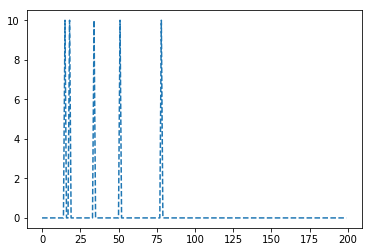

In [21]:
# plt.plot(OLS.coef_, label='OLS coefficients')
plt.plot(coef, '--', label='original coefficients')
# plt.legend(loc='best')
# plt.title("OLS R^2: %f"
#           % (r2_score_OLS))
plt.show()

### 3.

In [99]:
lasso_pipeline = make_pipeline(Lasso(random_state=123))
lasso_hyperparameters = { 
    'lasso__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 5, 10] 
}
    
model = GridSearchCV(lasso_pipeline, lasso_hyperparameters, cv=10, n_jobs=-1)
model.fit(X_train, y_train)
print('Lasso model fitted')
print('Best score:', model.best_score_)
display(model.best_estimator_)
print('The optimal hyperparameter (alpha) is: {}'.format(model.best_params_['lasso__alpha']))

Lasso model fitted
Best score: 0.9999985071110141


/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('lasso', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False))])

The optimal hyperparameter (alpha) is: 0.01


### 4.

In [72]:
model = GridSearchCV(lasso_pipeline, lasso_hyperparameters, cv=25, n_jobs=-1)
model.fit(X_train, y_train)
print('The optimal hyperparameter (alpha) is: {}'.format(model.best_params_['lasso__alpha']))

The optimal hyperparameter (alpha) is: 0.01


#### Explanation

They way we've approached this, using a pipeline with multiple hyperparameters, we are seeing little fluctuation in the optimal alpha no matter the number of folds. We think that's because this is designed to use the parameter grid (in which we've supplied multiple alpha parameters) to arrive at the optimal hyperparameters for the "best estimator".

Let's look at manually setting the alpha and plotting the results...

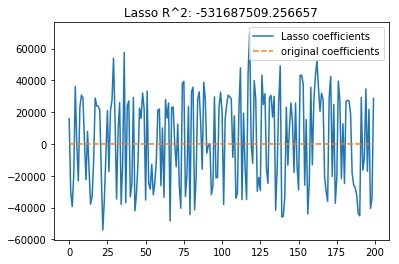

In [68]:
al = 10^-5
lasso = Lasso(alpha=al)

y_pred = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred)
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f"
          % (r2_score_lasso))
plt.show()

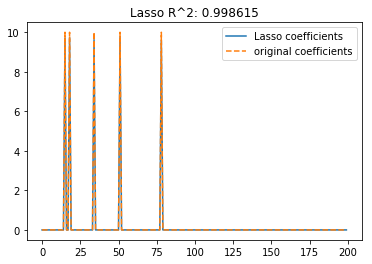

In [70]:
alpha = 0.3
lasso = Lasso(alpha=alpha)

y_pred = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred)
#print(lasso)
plt.plot(lasso.coef_, label='Lasso coefficients')
plt.plot(coef, '--', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f"
          % (r2_score_lasso))
plt.show()

#### What's Happening?

Lasso regresion uses the L1 (absolute size) penalty. This means that it could lead to coefficients which are exactly zero. This is how automatic feature selection happens. Essentially, a stronger penalty (alpha) leads to more coefficients being pushed to zero. That's exactly what's happening in the charts above.

The first chart (with a very small alpha) is leaving lots of coefficients on the table and thus more features are being taken into account for that model. This leaves us with a very bad R2 score.

The second chart (with a bigger alpha) has pushed almost all of the coefficients to zero and leaves us with a model that almost perfectly matches our original set of coefficients. We are provided with a much better R2 score as a result.

These are the trends we expect to be seeing. Cross-validation (GridSearchCV) has essentially run multiple calculations over our dataset and automatically chosen the best alpha that most closely matches our original coefficients so that we don't have to generate the above charts manually. We simply supply it with a list of alphas.

### Problem 3
Read Shannon’s 1948 paper ’A Mathematical Theory of Communication’. Focus on pages 1-19 (up
to Part II), the remaining part is more relevant for communication.
http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf
Summarize what you learned briefly (e.g. half a page).

### Problem 4: Scraping, Entropy and ICML papers.
ICML – the International Conference on Machine Learning – is a top research conference in Machine
learning. Scrape all the pdfs of all ICML 2019 papers from http://proceedings.mlr.press/v97/.
1. What are the top 10 common words in the ICML papers?
1
2. Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy
of Z.
3. Synthesize a random paragraph using the marginal distribution over words.
4. (Optional) Synthesize a random paragraph using an n-gram model on words. Synthesize
a random paragraph using any model you want. Top five synthesized text paragraphs win
bonus!

### Problem 5: Logistic Regression
The following is a logistic regression problem using a real data set, made available by the authors of the book “Applied Regression and Muiltilevel Modeling” by Gelman and Hill.<br>
Download the data from the book, which you can find here http://www.stat.columbia.edu/
~gelman/arm/software/. In particular, we are interested in the arsenic data set. The file
wells.dat contains data on 3,020 households in Bangladesh. For each family, the natural arsenic level of each well was measured. In addition, the distance to the nearest safest well was
measured. Each family is also described by a feature that relates to their community involvement,
and a feature that gives the education level of the head of household. We are interested in building
a model that predicts whether the family decided to switch wells or not, based on being informed
of the level of arsenic in the well. Thus the “label” for this problem is the binary vector that is the
first column of the dataset, labeled “switch.” <br>
1. Fit a logistic regression model using only an offset term and the distance to the nearest safe well. 
2. Plot your answer: that is, plot the probability of switching wells as a function of the distance to the nearest safe well.
3. Interpreting logistic regression coefficients: Use the “rule-of-4” discussed in class on Thursday, to interpret the solution: what can you say about the change in the probability of switching wells, for every additional 100 meters of distance?
4. Now solve a logistic regression incorporating the constant term, the distance and also arsenic levels. Report the coefficients
5. Next we want to answer the question of which factor is more significant, distance, or arsenic levels? This is not a well specified question, since these two features have different units.
One natural choice is to ask if after normalizing by the respective standard deviations of each feature, if moving one unit in one (normalized) feature predicts a larger change in probability of switching wells, than moving one unit in the other (also normalized) feature. Use this reasoning to answer the question.
6. Now consider all the features in the data set. Also consider adding interaction terms among all features that have a large main effect. Use cross validation to build the best model you can (using your training set only), and then report the test error of your best model.1
7. (Optional) Now also play around with $l_1$ and $l_2$ regularization, and try to build the most accurate model you can (accuracy computed on the test data).